In [1]:
library(data.table)
library(caret)
library(pROC)
library(randomForest)
load("projetdatascience.rda")

Loading required package: lattice
Loading required package: ggplot2
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin



In [1]:
vec_names         = names(projetTrain)
nb_lignes         = nrow(projetTrain)
vec_taux          = rep(0,length(vec_names))
vec_factors       = rep(0,length(vec_names))
index             = 1
data.informations = data.table(
                         feature=vec_names, 
                         taux=vec_taux,
                         factors=vec_factors
                        )


for(name in data.informations$feature){
    data.informations[index,  taux := (sum( is.na(projetTrain[,name, with=FALSE])) / nb_lignes)*100] 
    data.informations[index,factors:= length(table(projetTrain[,name, with=FALSE]))]
    index=index+1
}

ERROR: Error in eval(expr, envir, enclos): objet 'projetTrain' introuvable


In [3]:
columnsToFactor = data.informations[factors<10]$feature
columnsToDrop   = data.informations[taux>17]$feature

In [4]:
projetTrain = projetTrain[,target:=ifelse(target==1,"OK","KO")]

In [5]:
for (feature in columnsToFactor) {    
    if(feature != "target" ) { projetValid[,feature:=as.factor(get(feature)),with=FALSE] }
    projetTrain[,feature:=as.factor(get(feature)),with=FALSE]
}
projetTrain$Product_Info_2 = as.factor(projetTrain$Product_Info_2)
projetValid$Product_Info_2 = as.factor(projetValid$Product_Info_2)

In [6]:
projetTrainClean = na.roughfix(projetTrain)

In [8]:
set.seed(30)
split = sample(nrow(projetTrainClean), floor(0.1*nrow(projetTrainClean)))
sub.train = projetTrainClean[split,]
sub.test  = projetTrainClean[-split,]

In [10]:
control    = trainControl(method="repeatedcv", number=4, repeats=2)
seed       = 7
metric     = "AUC"
mtry       = floor(sqrt(ncol(sub.train)))
tunegrid   = expand.grid(.mtry=mtry)

In [11]:
rf_default = train(target~., 
                   data=sub.train,
                   method="rf",
                   metric=metric,
                   tuneGrid=tunegrid,
                   trControl=control,
                   importance=TRUE,
                   localImp=TRUE,
                   proximity=TRUE)

Warning message in train.default(x, y, weights = w, ...):
"The metric "AUC" was not in the result set. Accuracy will be used instead."

In [16]:
print(rf_default)

Random Forest 

5138 samples
 127 predictor
   2 classes: 'KO', 'OK' 

No pre-processing
Resampling: Cross-Validated (4 fold, repeated 2 times) 
Summary of sample sizes: 3854, 3854, 3853, 3853, 3853, 3854, ... 
Resampling results:

  Accuracy   Kappa    
  0.8241541  0.5863842

Tuning parameter 'mtry' was held constant at a value of 11
 


Warning message in train.default(x, y, weights = w, ...):
"The metric "AUC" was not in the result set. Accuracy will be used instead."

Random Forest 

5138 samples
 127 predictor
   2 classes: 'KO', 'OK' 

No pre-processing
Resampling: Cross-Validated (4 fold, repeated 2 times) 
Summary of sample sizes: 3854, 3853, 3853, 3854, 3854, 3854, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   10   0.8223046  0.5805599
   13   0.8227914  0.5846728
   21   0.8259054  0.5972706
   34   0.8248364  0.5990302
   60   0.8273662  0.6075873
   67   0.8277556  0.6087831
   94   0.8267820  0.6078712
  163   0.8247382  0.6049647
  173   0.8245435  0.6051647
  175   0.8237647  0.6034607

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 67. 


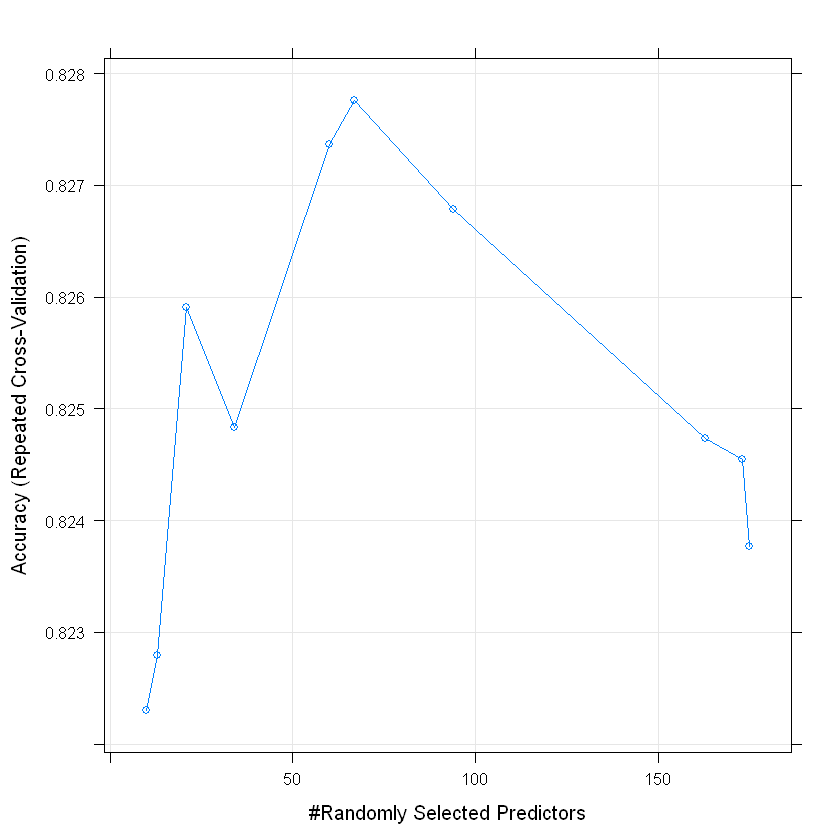

In [17]:
control   = trainControl(method="repeatedcv",
                        number=4,
                        repeats=2,
                        search="random")

rf_random = train(target~.,
                   data=sub.train,
                   method="rf",
                   metric=metric,
                   tuneLength=10,
                   trControl=control)
print(rf_random)
plot(rf_random)

In [18]:
result.predicted.prob <- predict(rf_random, sub.test , type="prob") # Prediction


Call:
roc.default(response = sub.test$target, predictor = result.predicted.prob$OK)

Data: result.predicted.prob$OK in 31047 controls (sub.test$target KO) < 15196 cases (sub.test$target OK).
Area under the curve: 0.9022

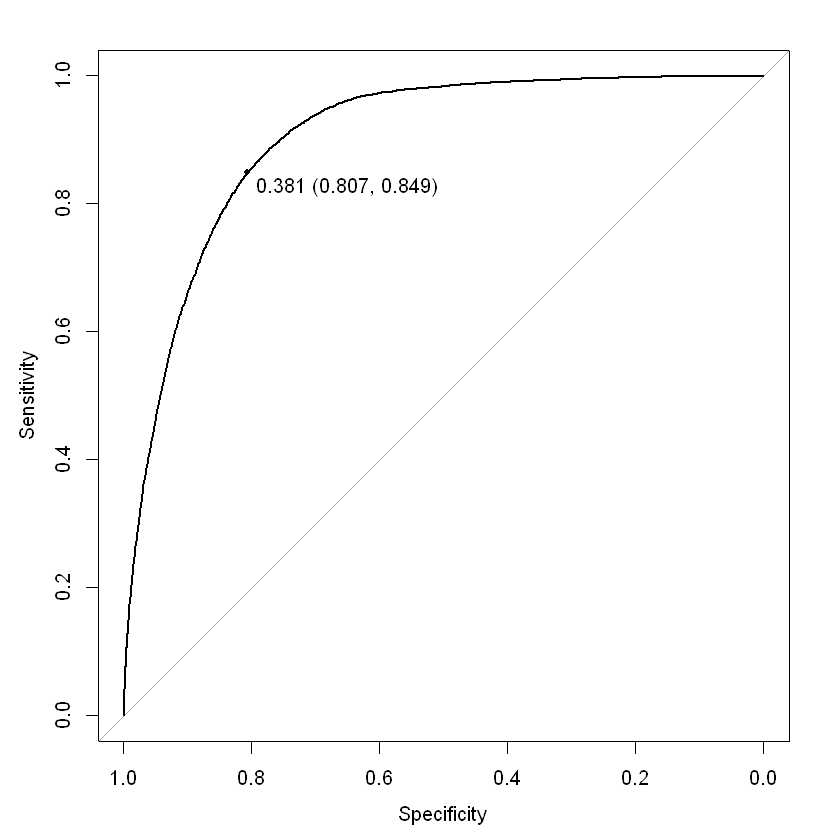

In [24]:
result.roc <- roc(sub.test$target, result.predicted.prob$OK) # Draw ROC curve.
plot(result.roc, print.thres="best", print.thres.best.method="closest.topleft")

In [25]:
result.coords <- coords(result.roc, "best", best.method="closest.topleft", ret=c("threshold", "accuracy"))
print(result.coords)#to get threshold and accuracy

threshold  accuracy 
0.3810000 0.8206431 


In [ ]:
table(sub.train$target,result.)

In [50]:
result.predicted.response = as.data.table(result.predicted.prob)

In [51]:
result.predicted.response[,OK := ifelse( (OK-KO)>0.10 , "OK","KO")]

,KO,OK
1,0.396,OK
2,0.886,KO
3,0.544,KO
4,0.494,KO
5,0.542,KO
6,0.354,OK
7,0.408,OK
8,0.938,KO
9,0.926,KO
10,0.946,KO


In [52]:
table(sub.test$target,result.predicted.response$OK)

    
        KO    OK
  KO 27619  3428
  OK  4740 10456

In [ ]:
save